ThinCurr Python Example: Compute frequency-response in a torus {#doc_tCurr_torus_fr}
==========
In this example we demonstrate how to compute frequency response for a model from both coils and the plasma mode computed in \ref doc_tCurr_torus_mode.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) and [pyvista](https://pyvista.org/) python packages, which are installable using `pip` or other standard methods.

In [1]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyvista
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load ThinCurr library

To load the ThinCurr python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` for binaries on macOS).

In [2]:
thincurr_python_path = os.getenv('OFT_ROOTPATH')
if thincurr_python_path is not None:
    sys.path.append(os.path.join(thincurr_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.ThinCurr import ThinCurr
from OpenFUSIONToolkit.ThinCurr.sensor import Mirnov, save_sensors

## Compute frequency response

### Setup ThinCurr model
We now create a \ref OpenFUSIONToolkit.OFT_env "OFT_env" instance for execution using four threads and a \ref OpenFUSIONToolkit.ThinCurr.ThinCurr "ThinCurr" instance that utilizes that execution environment. Once created, we setup the model from an existing HDF5 and XML mesh definition using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_model "setup_model()".

We also initialize I/O for this model using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_io "setup_io()" to enable output of plotting files for 3D visualization in [VisIt](https://visit-dav.github.io/visit-website/index.html), [Paraview](https://www.paraview.org/), or using [pyvista](https://pyvista.org/) below.

In [3]:
myOFT = OFT_env(nthreads=4)
tw_torus = ThinCurr(myOFT)
tw_torus.setup_model(mesh_file='thincurr_ex-torus.h5',xml_filename='oft_in.xml')
tw_torus.setup_io()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   v1_beta6
Revision id:          681e857
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    4
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_64910/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


Creating thin-wall model
 Orientation depth =        3122
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =         2394
  # of edges     =         7182
  # of cells     =         4788
  # of holes     =            2
  # of Vcoils    =            0
  # of closures  =            1
  # of Icoils    =            1

  Building holes

  Loading region resistivity:
     1  1.2570E-05


### Create sensor file
Before running the main calculations we will also define some sensors to measure the magnetic field. In ThinCurr all sensors measure the flux passing through a 3D path of points, but there are several helper classes to define common sensors (eg. \ref OpenFUSIONToolkit.ThinCurr.sensor.circular_flux_loop "Poloidal flux" and \ref OpenFUSIONToolkit.ThinCurr.sensor.Mirnov "Mirnovs"). Here we define two Mirnov sensors to measure the Z-component of the magnetic field 5 cm on either side of the torus. \ref OpenFUSIONToolkit.ThinCurr.sensor.save_sensors "save_sensors()" is then used to save the resulting sensor for later use.

In [4]:
sensors = [
    Mirnov([1.45,0.0,0.0], [0.0,0.0,1.0], 'Bz_inner'),
    Mirnov([1.55,0.0,0.0], [0.0,0.0,1.0], 'Bz_outer'),
]
save_sensors(sensors)

### Compute self-inductance and resistivity matrices
With the model setup, we can now compute the self-inductance and resistivity matrices. A numpy version of the self-inductance matrix will be stored at \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.Lmat "tw_plate.Lmat". By default the resistivity matrix is not moved to python as it is sparse and converting to dense representation would require an increase in memory. These matrices correspond to the $\textrm{L}$ and $\textrm{R}$ matrices for the physical system

$\textrm{L} \frac{\partial I}{\partial t} + \textrm{R} I = V$

**Note:** For larger models calculating the self-inductance may take some time due to the $N^2$ interaction of the elements (see \ref doc_thincurr_ex4 for more information).

In [5]:
tw_torus.compute_Lmat()
tw_torus.compute_Rmat()

 Building element<->element self inductance matrix
     Time =  3s          
 Building resistivity matrix


## Compute frequency response from coils
For the first case we will compute the frequency response on the model to current driven in the coil set specified in `oft_in.xml` at 1 kHz. To do this we first compute the coil to model mutual inductance matrix using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.compute_Mcoil "tw_plate.compute_Mcoil()". Then we compute a purely real driver voltage by using the first row of this matrix (equivalent to multiplying by 1). Finally we use \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.compute_freq_response "tw_plate.compute_freq_response()" to compute the frequency response to this input.

In [6]:
coil_current = 1.E4
Mcoil = tw_torus.compute_Mcoil()
driver = np.zeros((2,tw_torus.nelems))
driver[0,:] = Mcoil[0,:]*coil_current
result = tw_torus.compute_freq_response(fdriver=driver,freq=1.E3)

 Building coil<->element inductance matrices
     Time =  0s          
 Building coil<->coil inductance matrix

 Starting Frequency-response run
   Frequency [Hz] =   1.00000E+03
 Starting GMRES solver
     0  0.000000E+00  1.133720E+01
    60  2.097016E-01  1.077125E-03  5.136466E-03
   120  2.105014E-01  1.787020E-05  8.489348E-05
   180  2.104196E-01  7.443754E-07  3.537576E-06
   240  2.104221E-01  1.549764E-09  7.365025E-09
   Time =   0.95368600000000003     


### Save currents to plot files
The resulting currents are saved for plotting using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.save_current "tw_plate.save_current()". Here we save the real (`Jr`) and Imaginary (`Ji`) components of the response for visualization. Once all fields have been saved for plotting \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.build_XDMF "tw_plate.build_XDMF()" to generate the [XDMF descriptor files](https://www.xdmf.org/index.php/XDMF_Model_and_Format) for plotting with VisIt of Paraview.

In [7]:
tw_torus.save_current(result[0,:],'Jr_coil')
tw_torus.save_current(result[1,:],'Ji_coil')
_ = tw_torus.build_XDMF()

Removing old Xdmf files
  Removed 23 files

Creating output files: oft_xdmf.XXXX.h5
  Found Group: thincurr
    Found Mesh: icoils
      # of blocks: 1
    Found Mesh: smesh
      # of blocks: 1


### Compute sensor mutual inductance matrices
We can also compute the pickup of sensors in response to both the coil and the eddy currents. To do this we compute the mutual coupling matrices between the sensors and model and the sensors and the driver coils (`icoils`). 

In [8]:
Msensor, Msc, _ = tw_torus.compute_Msensor('floops.loc')


 Loading floop information:
   # of floops =           2
 Building element->sensor inductance matrix
 Building coil->sensor inductance matrix


### Print probe signals for frequency response

In [9]:
probe_signals = np.dot(result,Msensor)
probe_signals[0,:] += np.dot(np.r_[coil_current],Msc)
for i in range(probe_signals.shape[1]):
    print('Real: {0:13.5E}, Imaginary: {1:13.5E}'.format(*probe_signals[:,i]))

Real:  -4.91207E-06, Imaginary:  -1.37454E-08
Real:   3.89336E-06, Imaginary:  -1.95259E-08


## Setup plasma mode driver model
We now create a second \ref OpenFUSIONToolkit.ThinCurr.ThinCurr "ThinCurr" instance for the plasma mode utilizes the same execution environment as above. For this case we also load the plasma mode current patterns created in \ref doc_tCurr_torus_mode.

In [10]:
tw_mode = ThinCurr(myOFT)
tw_mode.setup_model(mesh_file='thincurr_mode.h5')
with h5py.File('thincurr_mode.h5', 'r+') as h5_file:
    mode_drive = np.asarray(h5_file['thincurr/driver'])


Creating thin-wall model
 Orientation depth =       12640
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =         6320
  # of edges     =        18960
  # of cells     =        12640
  # of holes     =            3
  # of Vcoils    =            0
  # of closures  =            2
  # of Icoils    =            0

  Building holes


## Compute coupling from plasma mode to torus model
To use this current distribution we need the inductive coupling between the mode currents and the ThinCurr model of the wall (`tw_torus`). This can be done using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.cross_eval "cross_eval()", which in this case computes the flux through each element on `tw_torus` due to the currents specified by weights `mode_drive` corresponding to the model `tw_mode`.

In [11]:
mode_driver = tw_mode.cross_eval(tw_torus,mode_drive)

 Applying MF element<->element inductance matrix
     Time = 17s          


## Compute frequency-response to plasma modes
We node compute the frequency-response as above using our new driver flux.

In [12]:
result = tw_torus.compute_freq_response(fdriver=mode_driver,freq=1.E-3)


 Starting Frequency-response run
   Frequency [Hz] =   1.00000E-03
 Starting GMRES solver
     0  0.000000E+00  5.096814E-04
    60  1.688020E-04  9.784296E-07  5.796316E-03
   120  1.732213E-04  4.697510E-07  2.711855E-03
   180  1.852839E-04  3.538349E-07  1.909690E-03
   240  1.927548E-04  2.728285E-07  1.415417E-03
   300  2.043648E-04  2.103251E-07  1.029165E-03
   360  2.102327E-04  1.653286E-07  7.864074E-04
   420  2.190889E-04  1.267897E-07  5.787135E-04
   480  2.228605E-04  9.916932E-08  4.449839E-04
   540  2.293144E-04  7.454560E-08  3.250803E-04
   600  2.314995E-04  5.727873E-08  2.474249E-04
   660  2.359685E-04  4.181621E-08  1.772110E-04
   720  2.371472E-04  3.116136E-08  1.314009E-04
   780  2.400631E-04  2.169509E-08  9.037242E-05
   840  2.406268E-04  1.547133E-08  6.429593E-05
   900  2.423754E-04  1.004465E-08  4.144253E-05
   960  2.426093E-04  6.695185E-09  2.759657E-05
  1020  2.435300E-04  3.884133E-09  1.594930E-05
  1080  2.436085E-04  2.325438E-09  9.545

### Save currents to plot files
The resulting currents are saved for plotting using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.save_current "tw_torus.save_current()". Here we save the real (`Jr`) and Imaginary (`Ji`) components of the response for visualization. Once all fields have been saved for plotting \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.build_XDMF "tw_torus.build_XDMF()" to generate the [XDMF descriptor files](https://www.xdmf.org/index.php/XDMF_Model_and_Format) for plotting with VisIt of Paraview. This method also returns a \ref OpenFUSIONToolkit.io.XDMF_plot_file "XDMF_plot_file" object, which can be used to read and interact with plot data in Python (see below).

In [13]:
tw_torus.save_current(result[0,:],'Jr_mode')
tw_torus.save_current(result[1,:],'Ji_mode')
plot_data = tw_torus.build_XDMF()

Removing old Xdmf files
  Removed 2 files

Creating output files: oft_xdmf.XXXX.h5
  Found Group: thincurr
    Found Mesh: icoils
      # of blocks: 1
    Found Mesh: smesh
      # of blocks: 1


In [14]:
Msensor_plasma, _, _ = tw_mode.compute_Msensor('floops.loc')


 Loading floop information:
   # of floops =           2
 Building element->sensor inductance matrix
 Building coil->sensor inductance matrix


## Print probe signals for frequency response

In [15]:
probe_signals = np.dot(result,Msensor) + np.dot(mode_drive,Msensor_plasma)
for i in range(probe_signals.shape[1]):
    print('Real: {0:13.5E}, Imaginary: {1:13.5E}'.format(*probe_signals[:,i]))

Real:  -2.86249E-01, Imaginary:  -8.96706E-06
Real:  -1.22518E-01, Imaginary:   6.46085E-06


# Plot current fields
Finally we plot the current vectors on the torus showing the imaginary eddy current structure for the plasma mode. The \ref OpenFUSIONToolkit.io.XDMF_plot_file "XDMF_plot_file" class provides functionality to work with the data stored in OFT plot files, including methods to generate information for 3D plotting in Python using [pyvista](https://pyvista.org/).

Plotting data is always associated with a specific mesh, which is itself associated with a physics group. In this case `ThinCurr` is the physics group and the data we are interested in is stored on the surface mesh `smesh`. The `plot_data['ThinCurr']['smesh']` is a \ref OpenFUSIONToolkit.io.XDMF_plot_mesh "XDMF_plot_mesh" object with further functionality for accessing data.

To plot the first eigenvector we first get the pyvista plotting grid using \ref OpenFUSIONToolkit.io.XDMF_plot_mesh.get_pyvista_grid() "get_pyvista_grid()" and then retrieve the vertex-centered field (`Ji_mode_v`) using \ref OpenFUSIONToolkit.io.XDMF_plot_mesh.get_field() "get_field()"

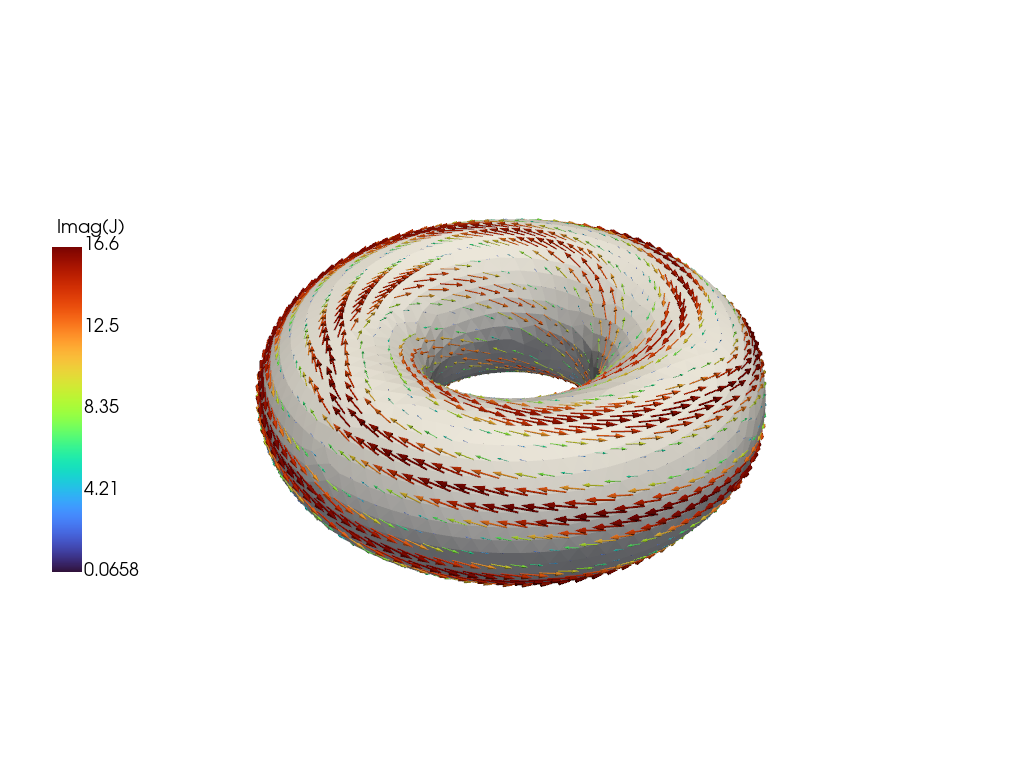

In [16]:
grid = plot_data['ThinCurr']['smesh'].get_pyvista_grid()
Ji = plot_data['ThinCurr']['smesh'].get_field('Ji_mode_v')

grid["vectors"] = Ji
grid.set_active_vectors("vectors")

p = pyvista.Plotter()
scale = 0.2/(np.linalg.norm(Ji,axis=1)).max()
arrows = grid.glyph(scale="vectors", orient="vectors", factor=scale)
p.add_mesh(arrows, cmap="turbo", scalar_bar_args={'title': "Imag(J)", "vertical": True, "position_y":0.25, "position_x": 0.05})
p.add_mesh(grid, color="white", opacity=1.0, show_edges=False)
p.show(jupyter_backend='static')